# Sentiment analysis of women's clothes reviews

## Part 3: Sentiment analysis based on customers rating.

The aim of this project is sentiment analysis to determined whether the product is recommended or not based on a review as an input text. In this approach I have used a recommendation based on customers rating where I assigned the values from the ranking to the positive, neutral and negative values.  I have used different machine learning algorithms to get more accurate predictions such as: Logistic Regression, Naive Bayes, Support Vector Machine (SVM), Random Forest and Ada Boosting as well.

### Dataset

The dataset comes from Woman Clothing Review that can be find at Kaggle. For this project I used three variables: Rating, Recommended and Review Text.

Attributes:

- Review Text (text): review text;
- Rating (numeric): product score granted by the customer from 1 Worst, to 5 Best;
- Recommended IND (numeric): customer recommends the product where 1 is recommended, 0 is not recommended.


## Import libriaries and data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('Womens Clothing Reviews.csv', header=0,index_col=0)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


Loading chosen variables: Rating, Recommended and Review Text.

In [6]:
df_text = df[['Rating', 'Recommended IND', 'Review Text']]
df_text.head()

,Rating,Recommended IND,Review Text
0,4,1,Absolutely wonderful - silky and sexy and comf...
1,5,1,Love this dress! it's sooo pretty. i happene...
2,3,0,I had such high hopes for this dress and reall...
3,5,1,"I love, love, love this jumpsuit. it's fun, fl..."
4,5,1,This shirt is very flattering to all due to th...


**First observations**:

In [7]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23486 entries, 0 to 23485
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Rating           23486 non-null  int64 
 1   Recommended IND  23486 non-null  int64 
 2   Review Text      22641 non-null  object
dtypes: int64(2), object(1)
memory usage: 733.9+ KB


Shape of data:

In [8]:
df_text.shape

(23486, 3)

Type of variables:

In [9]:
df_text.dtypes

,0
Rating,int64
Recommended IND,int64
Review Text,object


Checking the missing values in data:

In [10]:
df_text.isnull().sum()

,0
Rating,0
Recommended IND,0
Review Text,845


The dataset includes information about 23486 women's clothes reviews placed in 3 columns. After first observations one can see that there are missing values in Review variable.

## Data preparation

Rename of chosen variables:

In [11]:
df_text = df_text.rename(columns={"Review Text": "Review", "Recommended IND":"Recommended"})
df_text.head()

,Rating,Recommended,Review
0,4,1,Absolutely wonderful - silky and sexy and comf...
1,5,1,Love this dress! it's sooo pretty. i happene...
2,3,0,I had such high hopes for this dress and reall...
3,5,1,"I love, love, love this jumpsuit. it's fun, fl..."
4,5,1,This shirt is very flattering to all due to th...


Deleting missing values in Review variable:

In [12]:
df_text.dropna(subset=['Review'], inplace=True)

In [13]:
df_text.isnull().sum()

,0
Rating,0
Recommended,0
Review,0


In [14]:
df_text['Review'] = df_text['Review'].astype(str)

Now I create a new column that will consider the ratings as follows: assign the values from the ranking to the positive, neutral and negative values. Rating 4 or higher to Positive, equal to 3 Neutral and rating 2 or less to Negative.

Function to assign rating class:

In [15]:
def rating(row):
    if row >= 4:
        return 'Positive'
    if row == 3:
        return 'Neutral'
    if row <= 2:
        return 'Negative'

In [16]:
df_text['Class'] = df_text['Rating'].apply(rating)

In [17]:
df_text.head()

,Rating,Recommended,Review,Class
0,4,1,Absolutely wonderful - silky and sexy and comf...,Positive
1,5,1,Love this dress! it's sooo pretty. i happene...,Positive
2,3,0,I had such high hopes for this dress and reall...,Neutral
3,5,1,"I love, love, love this jumpsuit. it's fun, fl...",Positive
4,5,1,This shirt is very flattering to all due to th...,Positive


Saved cleaned dataset:

In [ ]:
CLEANED_DATA_PATH = r'data\reviews_class.csv'

In [ ]:
df_text.to_csv(CLEANED_DATA_PATH, encoding='utf-8')

## Basic data analysis

Checking proportion target class variable:

In [18]:
df_text['Class'].value_counts()

,count
Class,
Positive,17448
Neutral,2823
Negative,2370


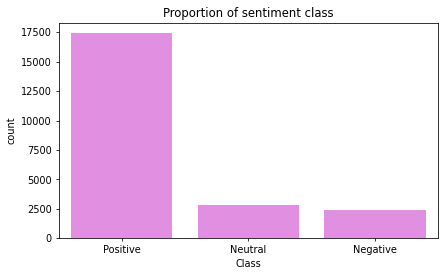

In [19]:
plt.figure(figsize=(7,4), dpi=70)
sns.countplot(x='Class',data=df_text, color='violet')
plt.xlabel('Class')
plt.title('Proportion of sentiment class');
plt.show()

The target class variable is imbalanced, where "Positive" class are more dominating than others.

Length of characters in each review:

In [20]:
df_text['length'] = df_text.Review.apply(len)
df_text.head()

,Rating,Recommended,Review,Class,length
0,4,1,Absolutely wonderful - silky and sexy and comf...,Positive,53
1,5,1,Love this dress! it's sooo pretty. i happene...,Positive,303
2,3,0,I had such high hopes for this dress and reall...,Neutral,500
3,5,1,"I love, love, love this jumpsuit. it's fun, fl...",Positive,124
4,5,1,This shirt is very flattering to all due to th...,Positive,192


Histogram of reviews length:

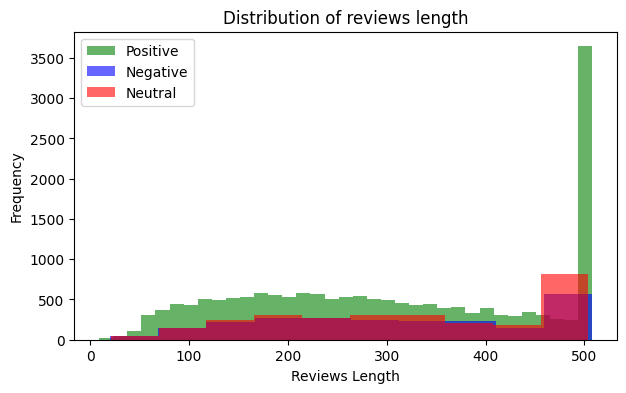

In [ ]:
plt.figure(figsize=(7, 4))
df_text[df_text.Class == 'Positive'].length.plot(bins=35, kind='hist', color='green', label='Positive', alpha=0.6)
df_text[df_text.Class == 'Negative'].length.plot(kind='hist', color='blue', label='Negative', alpha=0.6)
df_text[df_text.Class == 'Neutral'].length.plot(kind='hist', color='red', label='Neutral', alpha=0.6)
plt.legend()
plt.xlabel("Reviews Length")
plt.title('Distribution of reviews length');
plt.show();

The largest reviews has over 500 characters but some of them are very short.

## Text Pre-processing

In this part I change text to tokens and convertion all of the words to lower case. Then I remove non-alphabetic character, bad characters, numbers and stop words. The next step I apply lemmatizing for each line of text.

In [21]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [22]:
stop = stopwords.words('english')
print(stop[::10])

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [23]:
#clothing stopwords
clothes =['dress','color','wear','top','sweater','material','shirt','jeans','pant',
          'skirt','order','white','black','fabric','blouse','sleeve','even', 'jacket']

In [24]:
lem = WordNetLemmatizer()

In [25]:
def clean_text(words: str) -> str:
    """Clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()
    return " ".join(text)

def remove_stopwords(review: str) -> str:
    """Removing stopwords"""
    text = [word.lower() for word in review.split() if word.lower() not in stop and word.lower() not in clothes]
    return " ".join(text)

def remove_numbers(text: str) -> str:
    """Removing numbers from text"""
    new_text = []
    for word in text.split():
        if not re.search('\d', word):
            new_text.append(word)
    return ' '.join(new_text)

def get_lemmatize(text: str) -> str:
    """Applying lemmatizing"""
    lem_text = [lem.lemmatize(word) for word in text.split()]
    return " ".join(lem_text)


In [26]:
df_text['Review'] = df_text['Review'].apply(clean_text)
df_text['Review'] = df_text['Review'].apply(remove_stopwords)
df_text['Review'] = df_text['Review'].apply(remove_numbers)
df_text['Review'] = df_text['Review'].apply(get_lemmatize)

In [27]:
df_text.head()

,Rating,Recommended,Review,Class,length
0,4,1,absolutely wonderful silky sexy comfortable,Positive,53
1,5,1,love sooo pretty happened find store glad bc n...,Positive,303
2,3,0,high hope really wanted work initially ordered...,Neutral,500
3,5,1,love love love jumpsuit fun flirty fabulous ev...,Positive,124
4,5,1,flattering due adjustable front tie perfect le...,Positive,192


## Build models

I have used the following classification models:
- Logistic Regression,
- Random Forest Classifier,
- Naive Bayes Classifier,
- SVM (Support Vector Machine),
- Ada Boosting.

To run machine learning algorithms need to convert the text files into numerical feature vectors. I have used bag of words model for modelling. This model convert the text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized TF-IDF representation (tf-idf transformer).

**Pipeline**

To make the vectorizer => transformer => SMOTE  => classifier easier to work with I have used Pipeline class in scikit-learn.

**Model Evaluation**

To evaluate the models I have used accuracy score and classification report(precision, recall, F1-score).

Spliting data into train and test set:

In [29]:
X = df_text['Review']
y = df_text['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

**Logistic regression**

In [30]:
model_log = imbpipeline(steps=[('vect', CountVectorizer(min_df=5, ngram_range=(1, 2))),
                               ('tfidf', TfidfTransformer()),
                               ('smote', SMOTE()),
                               ('clf', LogisticRegression())])

model_log.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_log.predict(X_test)

In [31]:
log_acc = accuracy_score(pred_y, y_test)
print('accuracy %s' % log_acc)
print(classification_report(ytest, pred_y))

accuracy 0.794435857805255
              precision    recall  f1-score   support

    Negative       0.50      0.54      0.52       489
     Neutral       0.40      0.43      0.42       628
    Positive       0.92      0.90      0.91      3412

    accuracy                           0.79      4529
   macro avg       0.61      0.62      0.61      4529
weighted avg       0.80      0.79      0.80      4529



**Random forest**

In [32]:
model_rf = imbpipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                      ('tfidf', TfidfTransformer()),
                      ('smote', SMOTE()),
                      ('clf-rf', RandomForestClassifier(n_estimators=50))])

model_rf.fit(X_train, y_train)

pred = model_rf.predict(X_test)

In [33]:
rf_acc = accuracy_score(pred, y_test)
print('accuracy %s' % rf_acc)
print(classification_report(ytest, pred))

accuracy 0.788474276882314
              precision    recall  f1-score   support

    Negative       0.59      0.31      0.41       489
     Neutral       0.46      0.11      0.18       628
    Positive       0.81      0.98      0.89      3412

    accuracy                           0.79      4529
   macro avg       0.62      0.47      0.49      4529
weighted avg       0.74      0.79      0.74      4529



**Naive Bayes**

In [34]:
model_nb = imbpipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                      ('tfidf', TfidfTransformer()),
                      ('smote', SMOTE()),
                      ('model',MultinomialNB()),
                      ])

model_nb.fit(X_train,y_train)

preds = model_nb.predict(X_test)

In [35]:
nb_acc = accuracy_score(preds, y_test)
print('accuracy %s' % nb_acc)
print(classification_report(ytest, preds))

accuracy 0.7683815411790682
              precision    recall  f1-score   support

    Negative       0.46      0.59      0.52       489
     Neutral       0.36      0.50      0.42       628
    Positive       0.95      0.84      0.89      3412

    accuracy                           0.77      4529
   macro avg       0.59      0.64      0.61      4529
weighted avg       0.81      0.77      0.79      4529



**SVM**

In [36]:
model_svm = imbpipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1, 2))),
                       ('tfidf', TfidfTransformer()),
                       ('smote', SMOTE()),
                       ('svm',LinearSVC()),
                       ])

model_svm.fit(X_train, y_train)

y_predict = model_svm.predict(X_test)

In [37]:
svm_acc = accuracy_score(y_predict, y_test)
print('accuracy %s' % svm_acc)
print(classification_report(ytest, y_predict))

accuracy 0.7917862662839479
              precision    recall  f1-score   support

    Negative       0.48      0.49      0.49       489
     Neutral       0.41      0.37      0.39       628
    Positive       0.90      0.91      0.91      3412

    accuracy                           0.79      4529
   macro avg       0.60      0.59      0.59      4529
weighted avg       0.79      0.79      0.79      4529



**Ada Boosting**

In [38]:
model_ab = imbpipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                       ('tfidf', TfidfTransformer()),
                       ('smote', SMOTE()),
                       ('ada', AdaBoostClassifier()),
                       ])

model_ab.fit(X_train, y_train)

y_pred = model_ab.predict(X_test)

In [39]:
ab_acc = accuracy_score(y_pred, y_test)
print('accuracy %s' % ab_acc)
print(classification_report(ytest, y_pred))

accuracy 0.677633031574299
              precision    recall  f1-score   support

    Negative       0.32      0.33      0.33       489
     Neutral       0.26      0.40      0.31       628
    Positive       0.87      0.78      0.82      3412

    accuracy                           0.68      4529
   macro avg       0.48      0.50      0.49      4529
weighted avg       0.73      0.68      0.70      4529



### Best model

I have tested five different models and check which one is the best:

In [40]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM', 'Ada Boosting'],
                      'Score': [log_acc, rf_acc, nb_acc, svm_acc, ab_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Logistic Regression,0.794436
3,SVM,0.791786
1,Random Forest,0.788474
2,Naive Bayes,0.768382
4,Ada Boosting,0.677633


## Summary

This project was aimed to used sentiment analysis to determined product recommendation. In this case I have used a recommendation based on customers rating. I have started with assigned the values from the ranking to the positive, neutral and negative values. To resolve the imbalance problem in the data I have used SMOTE method. Finally I started training 5 different classification models. The best model was Logistic Regression algorithm which reached accuracy equal to 79 %.